In [1]:
import os
from glob import glob
import re
from collections import defaultdict, OrderedDict

PROOF_DIR = os.path.expanduser('~/theory-proofs')
LINE_PATTERN = re.compile(r'^(\d+). (.+) \[([^0-9]*)([0-9,]*)\]$')
VAR_PATTERN = re.compile(r'(X\d+)([^0-9]|$)')

def proof_paths():
    return glob(PROOF_DIR + '/*.proof')

def clean_formula(formula):
    formula = formula.replace("(TD)", "").strip()
    var_map = {'next': 0}

    def sub_var(match):
        digits, rest = match.groups()
        n = int(digits[1:])
        if n not in var_map:
            var_map[n] = var_map['next']
            var_map['next'] += 1
        return "Y{}{}".format(var_map[n], rest)

    return VAR_PATTERN.subn(sub_var, formula)[0]

def parse_proof(proof):
    result = OrderedDict()

    for line in proof.split('\n'):
        match = LINE_PATTERN.match(line)
        if match:
            index, formula, inference, parents = match.groups()
            parents = [int(parent) for parent in parents.split(',')] if parents else []
            result[int(index)] = (clean_formula(formula), inference.strip(), parents)
    return result

def theory_results(proof):
    axioms = {}
    lemmas = {}
    for key, (formula, inference, parents) in proof.items():
        if inference == 'theory axiom':
            axioms[key] = formula
        elif parents and all(parent in axioms or parent in lemmas for parent in parents):
            lemmas[key] = formula
    return (set(axioms.values()), set(lemmas.values()))

In [26]:
print("{} proofs available.".format(len(proof_paths())))

19344 proofs available.


In [27]:
problem_axioms = defaultdict(list)
problem_lemmas = defaultdict(list)

axiom_counts = defaultdict(lambda: 0)
lemma_counts = defaultdict(lambda: 0)

for path in proof_paths():
    with open(path, 'r') as f:
        problem = os.path.basename(os.path.splitext(path)[0])
        axioms, lemmas = theory_results(parse_proof(f.read()))
        for axiom in axioms:
            problem_axioms[problem].append(axiom)
            axiom_counts[axiom] += 1
        for lemma in lemmas:
            problem_lemmas[problem].append(lemma)
            lemma_counts[lemma] += 1

In [28]:
print("Count\tAxiom\n")
for axiom, count in sorted(axiom_counts.items(), key=lambda x: x[1], reverse=True):
    print("{}\t{}".format(count, axiom))

print("\n\n---------------------\n\n")

print("Count\tLemma\n")
for lemma, count in sorted(lemma_counts.items(), key=lambda x: x[1], reverse=True):
    print("{}\t{}".format(count, lemma))

Count	Axiom

1711	$less(Y0,Y1) | $less(Y1,Y0) | Y1 = Y0
1425	~$less(Y0,Y0)
1104	~$less(Y0,Y1) | ~$less(Y2,Y0) | $less(Y2,Y1)
672	$less(Y0,$sum(Y1,1)) | $less(Y1,Y0)
390	$sum(Y0,Y1) = $sum(Y1,Y0)
117	0 = $sum(Y0,$uminus(Y0))
106	$sum(Y0,0) = Y0
100	~$less(Y0,$sum(Y1,1)) | ~$less(Y1,Y0)
84	$select($store(Y0,Y1,Y2),Y1) = Y2
63	$select(Y0,Y1) = $select($store(Y0,Y2,Y3),Y1) | Y2 = Y1
51	$uminus($uminus(Y0)) = Y0
49	$less($sum(Y0,Y1),$sum(Y2,Y1)) | ~$less(Y0,Y2)
48	$sum(Y0,$sum(Y1,Y2)) = $sum($sum(Y0,Y1),Y2)
28	~$less(Y0,Y1) | ~$less(Y1,Y2) | $less(Y0,Y2)
28	$product(Y0,Y1) = $product(Y1,Y0)
26	$less(Y0,$sum(Y1,1.0)) | $less(Y1,Y0)
21	$less(Y0,Y1) | $less(Y1,Y0) | Y0 = Y1
16	$less(Y0,$sum(Y1,1/1)) | $less(Y1,Y0)
16	$less(Y0,Y1) | $less(Y1,$sum(Y0,1))
15	~$less(Y0,Y1) | $less($sum(Y0,Y2),$sum(Y1,Y2))
14	$sum(Y0,$uminus(Y0)) = 0
12	~$less(Y0,Y1) | ~$less(Y1,$sum(Y0,1))
11	0.0 = $sum(Y0,$uminus(Y0))
8	$product(Y0,1) = Y0
8	0/1 = $sum(Y0,$uminus(Y0))
5	Y0 = Y1 | $select(Y2,Y1) = $select($store(Y

In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

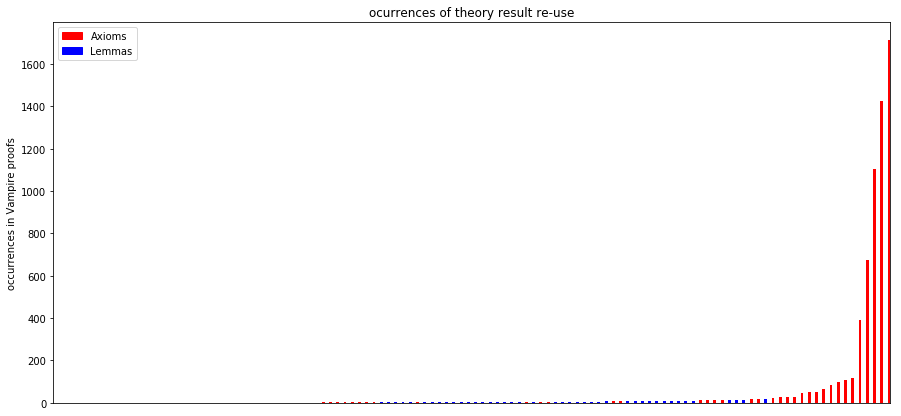

In [30]:
data = list((f, 'blue' if islemma else 'red') for f, islemma in sorted(
    [(a, False) for a in axiom_counts.values()] + [(l, True) for l in lemma_counts.values()]
))
frequencies, colours = zip(*data)

plt.figure(figsize=(15, 7))
plt.title('ocurrences of theory result re-use')
plt.bar(np.arange(len(data)), frequencies, 0.4, color=colours)
plt.autoscale(enable=True, axis='x', tight=True)
plt.tick_params(
    axis='x',
    which='both',
    bottom='off',
    labelbottom='off'
)
plt.ylabel('occurrences in Vampire proofs')
ax_patch = Patch(color='red', label='Axioms')
lem_patch = Patch(color='blue', label='Lemmas')
plt.legend(handles=[ax_patch, lem_patch], loc=2)
plt.show()